In [108]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

In [109]:
learning_rate = 0.001
dropout = 0.5
batch_size = 100
iterations = 10000
validation_data = 500
images_display = 5

In [110]:
train_data = pd.read_csv('/Users/mac/Downloads/train.csv')
print train_data.head()

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0         

In [111]:
images = train_data.iloc[:,1:].values
images = images.astype(np.float)

images = np.multiply(images,1.0/255.0)


In [112]:
image_size = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

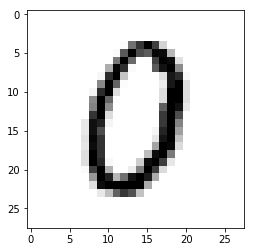

In [113]:
def display(image):
    one_image = image.reshape(image_width,image_height)
    plt.imshow(one_image,cmap= cm.binary)

display(images[images_display])

In [114]:
labels_flat = train_data[[0]].values.ravel()

In [115]:
labels_count = np.unique(labels_flat).shape[0]

In [116]:
def onehotvector(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels)*num_classes
    labels_onehot = np.zeros((num_labels,num_classes))
    labels_onehot.flat[index_offset + labels_dense.ravel()]=1
    return labels_onehot
labels = onehotvector(labels_flat,labels_count)
labels = labels.astype(np.uint8)

In [117]:
validation_images = images[:validation_data]
validation_labels = labels[:validation_data]

train_images = images[validation_data:]
train_labels = labels[validation_data:]

In [118]:
# we will begin now the nueral network part, building our training model
def weight(shape):
    initial = tf.truncated_normal(shape, stddev =0.1)
    return tf.Variable(initial)
def bias(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [119]:
def conv2d(x,W):
    return tf.nn.conv2d(x ,W,strides=[1,1,1,1], padding='SAME')

In [120]:
def maxpool(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides = [1,2,2,1], padding='SAME')

In [121]:
x = tf.placeholder('float', shape=[None,image_size])
y_ = tf.placeholder('float', shape=[None,labels_count])

In [122]:
#first conv layer
W_conv1 = weight([5,5,1,32])
b_conv1 = bias([32])

image = tf.reshape(x,[-1,image_width,image_height,1])

h_conv1 = tf.nn.relu(conv2d(image,W_conv1)+b_conv1)
h_pool1 = maxpool(h_conv1)

layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,8)) 

layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))

layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8)) 

In [123]:
W_conv2 = weight([5, 5, 32, 64])
b_conv2 = bias([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = maxpool(h_conv2)


layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  

layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))

layer2 = tf.reshape(layer2, (-1, 14*4, 14*16)) 

In [124]:
W_fc1 = weight([7 * 7 * 64, 1024])
b_fc1 = bias([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [125]:
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [126]:
W_fc2 = weight([1024, labels_count])
b_fc2 = bias([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [127]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [128]:
predict = tf.argmax(y,1)

In [129]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [ ]:
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)


Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [ ]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(iterations):

    #get new batch
    batch_xs, batch_ys = next_batch(batch_size)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == iterations:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(validation_data):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:batch_size], 
                                                            y_: validation_labels[0:batch_size], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: dropout})

training_accuracy / validation_accuracy => 0.10 / 0.07 for step 0
training_accuracy / validation_accuracy => 0.16 / 0.16 for step 1
training_accuracy / validation_accuracy => 0.21 / 0.26 for step 2
training_accuracy / validation_accuracy => 0.15 / 0.18 for step 3
training_accuracy / validation_accuracy => 0.34 / 0.27 for step 4
training_accuracy / validation_accuracy => 0.31 / 0.33 for step 5
training_accuracy / validation_accuracy => 0.44 / 0.43 for step 6
training_accuracy / validation_accuracy => 0.46 / 0.40 for step 7
training_accuracy / validation_accuracy => 0.51 / 0.43 for step 8
training_accuracy / validation_accuracy => 0.65 / 0.54 for step 9
training_accuracy / validation_accuracy => 0.55 / 0.51 for step 10
training_accuracy / validation_accuracy => 0.78 / 0.72 for step 20
training_accuracy / validation_accuracy => 0.77 / 0.82 for step 30
training_accuracy / validation_accuracy => 0.93 / 0.86 for step 40
training_accuracy / validation_accuracy => 0.93 / 0.93 for step 50
train

In [ ]:
if(validation_data):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

In [ ]:
# read test data from CSV file 
test_images = pd.read_csv('/Users/mac/Downloads/test.csv').values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))


# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//batch_size):
    predicted_lables[i*batch_size : (i+1)*batch_size] = predict.eval(feed_dict={x: test_images[i*batch_size : (i+1)*batch_size], 
                                                                                keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))

# output test image and prediction
display(test_images[images_display])
print ('predicted_lables[{0}] => {1}'.format(images_display,predicted_lables[images_display]))

# save results
np.savetxt('submission_softmax.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')